<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Informatics-Collaboration-Network---Full-Graph" data-toc-modified-id="Informatics-Collaboration-Network---Full-Graph-1">Informatics Collaboration Network - Full Graph</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1.1">Setup</a></span></li></ul></li><li><span><a href="#Full-Graph-Visualisation" data-toc-modified-id="Full-Graph-Visualisation-2">Full Graph Visualisation</a></span><ul class="toc-item"><li><span><a href="#Descriptive-Statistics" data-toc-modified-id="Descriptive-Statistics-2.1">Descriptive Statistics</a></span><ul class="toc-item"><li><span><a href="#Degree-distribution" data-toc-modified-id="Degree-distribution-2.1.1">Degree distribution</a></span></li><li><span><a href="#Clustering-Coefficients" data-toc-modified-id="Clustering-Coefficients-2.1.2">Clustering Coefficients</a></span></li><li><span><a href="#Distance-Measure-for-subgraphs" data-toc-modified-id="Distance-Measure-for-subgraphs-2.1.3">Distance Measure for subgraphs</a></span></li></ul></li></ul></li><li><span><a href="#Largest-Connected-Component" data-toc-modified-id="Largest-Connected-Component-3">Largest Connected Component</a></span><ul class="toc-item"><li><span><a href="#Descriptive-Statistics" data-toc-modified-id="Descriptive-Statistics-3.1">Descriptive Statistics</a></span><ul class="toc-item"><li><span><a href="#Degree-Distribution" data-toc-modified-id="Degree-Distribution-3.1.1">Degree Distribution</a></span></li><li><span><a href="#Clustering-coefficients" data-toc-modified-id="Clustering-coefficients-3.1.2">Clustering coefficients</a></span></li><li><span><a href="#Average-Path-and-Diameter" data-toc-modified-id="Average-Path-and-Diameter-3.1.3">Average Path and Diameter</a></span></li></ul></li><li><span><a href="#Community-Detection" data-toc-modified-id="Community-Detection-3.2">Community Detection</a></span></li></ul></li></ul></div>

## Informatics Collaboration Network - Full Graph

### Setup

In [1]:
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, csv
import networkx as nx
import cPickle as pkl
from helper import *

In [2]:
# The lookup tables:
lookup_pub = pd.read_pickle(
    path = '../data/lookup_pub.pkl')
pd_poinf = pd.read_pickle('../data/lookup_poinf.pkl')

In [4]:
pd_poinf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, d089bb44-7d0b-4b3f-b556-27def993d1d1 to ccd9cd8c-9aee-4ede-a388-f82641ee8d29
Data columns (total 9 columns):
last_name          224 non-null object
first_name         224 non-null object
perseonal_url      224 non-null object
position           224 non-null object
parent             224 non-null object
institute          224 non-null object
full_name          224 non-null object
institute_class    224 non-null int64
alias              224 non-null object
dtypes: int64(1), object(8)
memory usage: 27.5+ KB


In [8]:
lookup_pub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8810 entries, 400818dc-63af-4a26-80c5-906f98e1f8ab to b2920a27-5293-4f4a-8874-4a0ea804d91a
Data columns (total 5 columns):
year          8810 non-null object
authors       8810 non-null object
shortnames    8809 non-null object
collab_id     8810 non-null object
edges         8810 non-null object
dtypes: object(5)
memory usage: 413.0+ KB


In [5]:
# Only need the institute_clas and id:
pd_poinf.drop(
    labels=['full_name', 'last_name', 'first_name', 'institute', 'alias'],
    axis=1,
    inplace=True)

In [6]:
institutes = pkl.load(open('../data/institutes.pkl'))

In [7]:
# Create a color map for each institute:
inst_by_color = {
    0: 'xkcd:silver',
    1: 'xkcd:cyan',
    2: 'xkcd:magenta',
    3: 'xkcd:indigo',
    4: 'xkcd:red',
    5: 'xkcd:lime',
    6: 'xkcd:goldenrod',
    7: 'xkcd:azure',
    8: 'xkcd:lavender',
    9: 'xkcd:grey green',
    10: 'xkcd:coral',
    'others': 'xkcd:claret'
}

In [11]:
# light up the nodes based on the institutes they belong to:
def color_by_inst(g):
    node_color = []
    for node in g:
        if len(str(node)) > 5: # individuals from informatics have a long unique id
            k = int(pd_poinf.institute_class.loc[[str(node)]])
            node_color.append(inst_by_color[k])
        else:
            node_color.append(inst_by_color['others'])
    return node_color

In [12]:
def add_inst_labels(ax, with_legend=True):
    for label in institutes.values():
        ax.scatter(
            [0], [0],
            color=inst_by_color[label],
            label=[name for (name, _k) in institutes.items() if _k == label][0])
    ax.scatter([0],[0],
              color=inst_by_color['others'],
              label='external')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.scatter([0],[0], color='white', s=100, edgecolors='none')
    return ax

## Full Graph Visualisation

In [9]:
all_edges = []
for listEdges in lookup_pub.edges:
    all_edges.extend(listEdges)

In [10]:
g_full = nx.from_edgelist(all_edges)
pos = nx.spring_layout(g_full)

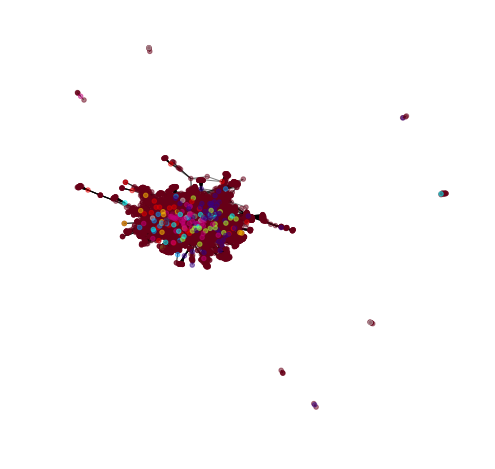

In [13]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax=add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    g_full,
    pos=pos,
    with_labels=False,
    ax=ax,
    alpha=.5,
    node_size=20,
    node_color=color_by_inst(g_full)
)
plt.savefig("full_graph.pdf", format='pdf', 
            bbox_inches="tight")

In [17]:
pos2 = nx.circular_layout(g_full)

In [81]:
poinf_in_full = [a for a in g_full.nodes if a in pd_poinf.index]

In [83]:
g_full_poinf = g_full.subgraph(poinf_in_full)

In [91]:
print(nx.info(g_full_poinf))

Name: Full collaboration Graph
Type: SubGraph
Number of nodes: 219
Number of edges: 474
Average degree:   4.3288


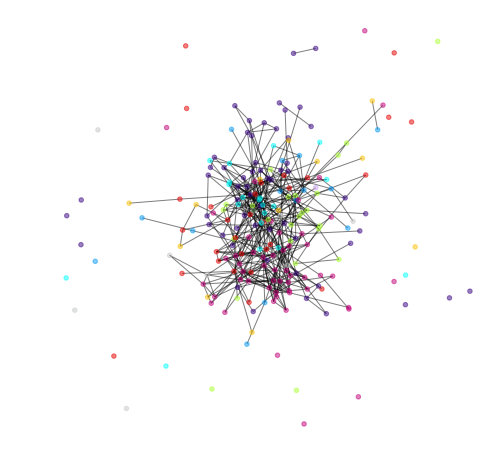

In [89]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax=add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    g_full_poinf,
    pos=nx.spring_layout(g_full_poinf, iterations=10),
    with_labels=False,
    ax=ax,
    alpha=.5,
    node_size=20,
    node_color=color_by_inst(g_full_poinf)
)

### Descriptive Statistics

In [14]:
g_full.name = 'Full collaboration Graph'
print(nx.info(g_full))

Name: Full collaboration Graph
Type: Graph
Number of nodes: 7898
Number of edges: 35866
Average degree:   9.0823


#### Degree distribution
In this section, we calculate the degree distribution of the collaboration graph, also providing apis for further degree distribution calculation

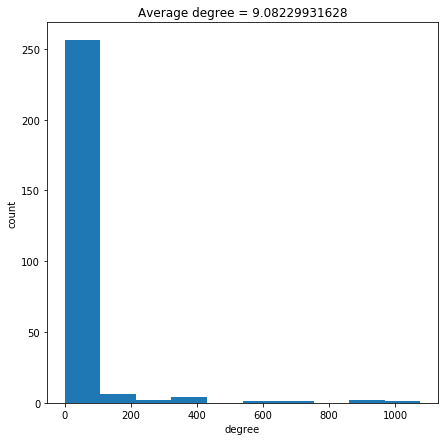

In [14]:
ax, degree_seq = degree_dist(g_full)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/goweiting/miniconda2/envs/python27/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/goweiting/miniconda2/envs/python27/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


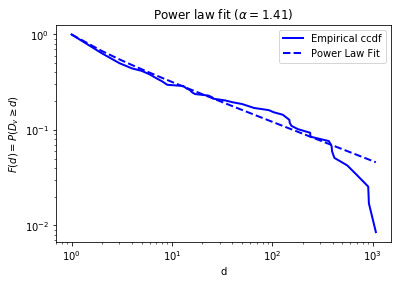

In [15]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
# plt.savefig("full_graph-degreedist.pdf", format='pdf', 
#             bbox_inches="tight")

#### Clustering Coefficients

In [16]:
cc = clustering_coeff(g_full)

In [17]:
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.813008680136


In [18]:
# The number of triangles for each nodes
triangle_nodes = nx.triangles(g_full)
transitivity_graph = nx.transitivity(g_full)

In [19]:
print('Transitivity:',transitivity_graph)

Transitivity: 0.291053234318


#### Distance Measure for subgraphs

In [20]:
gccs, percentage = generateGCC(g_full)

component 1: 99.48%
component 2: 0.15%
component 3: 0.09%
component 4: 0.08%
component 5: 0.06%
component 6: 0.05%
component 7: 0.05%
component 8: 0.04%


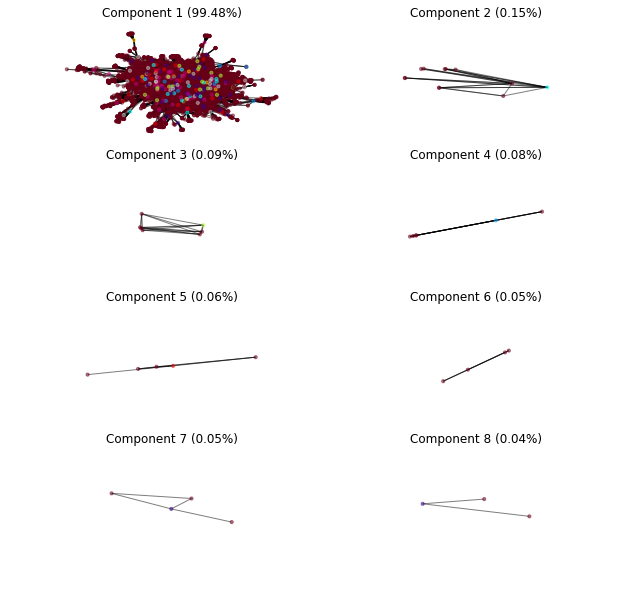

In [21]:
# display the connected components:
fig = plt.figure(figsize=(10,10))
num_col = len(gccs)/2
for i, g in enumerate(gccs,1):
    percent = percentage[i-1]
    ax = fig.add_subplot(num_col,2,i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        alpha=.5,
        node_size=10,
        pos=pos)
plt.savefig("full_graph-gccs.pdf", format='pdf', 
            bbox_inches="tight")

## Largest Connected Component

In [21]:
main_gcc = gccs[0]
pos_gcc = nx.spring_layout(main_gcc)

In [28]:
pos_gcc2 = nx.circular_layout(main_gcc)

In [22]:
print('number of nodes in largest connected component:', len(main_gcc))

number of nodes in largest connected component: 7857


In [23]:
print(nx.info(main_gcc))

Name: Full collaboration Graph
Type: Graph
Number of nodes: 7857
Number of edges: 35783
Average degree:   9.1086


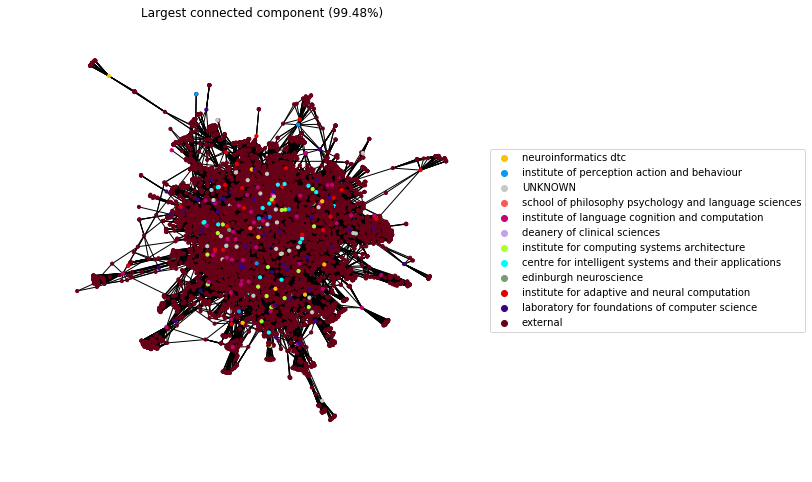

In [25]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=10,
    node_color=color_by_inst(main_gcc))
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]))
plt.savefig("full_graph-LargestCC.pdf", format='pdf', bbox_inches="tight")

### Descriptive Statistics

#### Degree Distribution

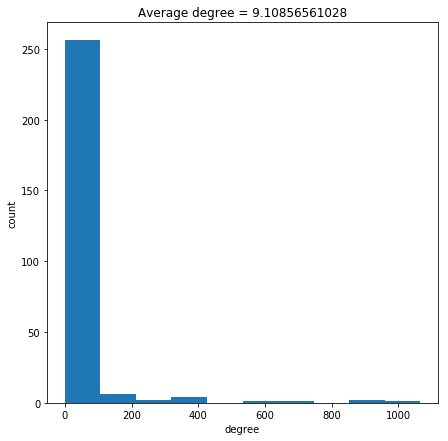

In [27]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


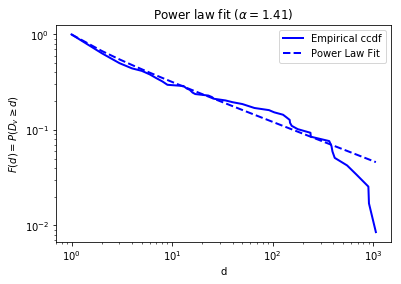

In [28]:
fig = power_law_fit(degree_seq)
plt.savefig("full_graph-LargestCC-powerlaw.pdf", format='pdf', 
            bbox_inches="tight")

#### Clustering coefficients

In [29]:
cc = clustering_coeff(main_gcc)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.812993641411


#### Average Path and Diameter

In [30]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 10


In [31]:
print('Average Path: ', nx.average_shortest_path_length(main_gcc)) # AVERAGE PATH

Average Path:  4.62115252216


### Community Detection
In this section, we use the [`community`](https://bitbucket.org/taynaud/python-louvain) package to detect communities in the largest connected component. 
We hypothesised that this will allow us to detect various institutes that have close working relationships

***Credit: https://blog.dominodatalab.com/social-network-analysis-with-networkx/***

In [32]:
import community

In [33]:
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]

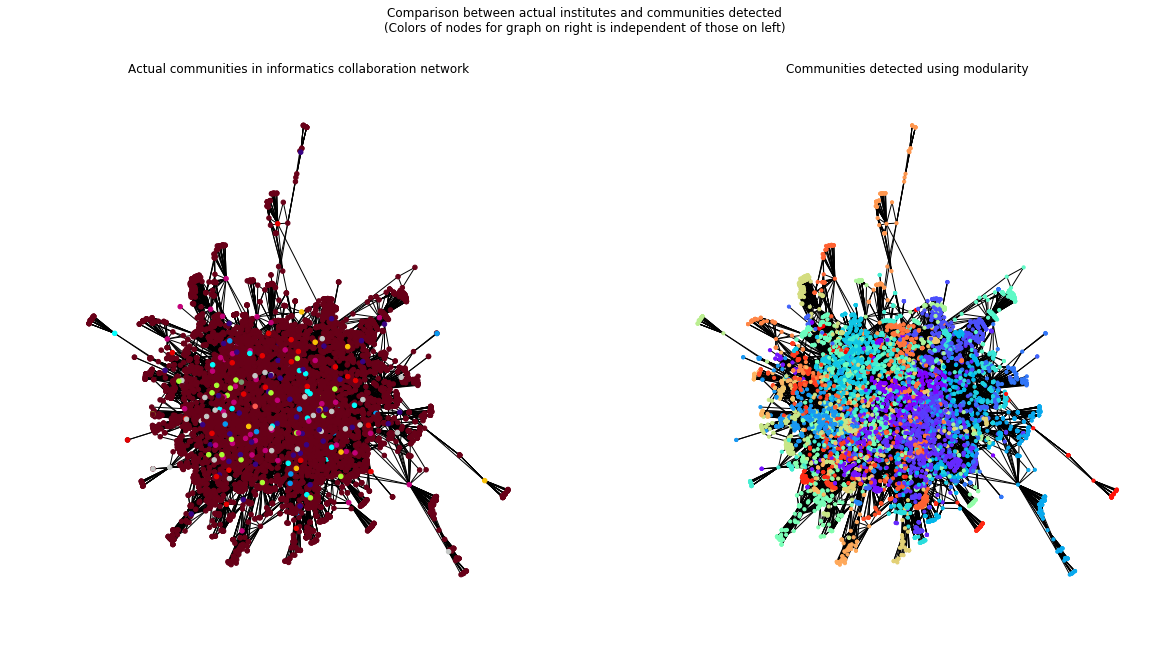

In [37]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=20,
    node_color=color_by_inst(main_gcc))

ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=10,
    with_labels=False)

plt.savefig(
    "full_graph-compareCommunities.pdf", format='pdf', bbox_inches="tight")

In [38]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

Number of communities detected = 40


In [26]:
poinf_in_gcc = [n for n in main_gcc.nodes if n in pd_poinf.index]
poinf_edge = [
    a for a in main_gcc.edges
    if a[0] in pd_poinf.index and a[1] in pd_poinf.index
]

In [31]:
g_poinf_in_gcc = main_gcc.subgraph(poinf_in_gcc)

In [47]:
gb = pd_poinf.groupby('institute_class')
shells = []
for k, grp in gb:
    shells.append(grp.index.values)

In [78]:
pos_poinf = nx.spring_layout(g_poinf_in_gcc, scale=10, iterations=10)
pos_poinf2 = nx.shell_layout(g_poinf_in_gcc, sorted(shells,key=len))

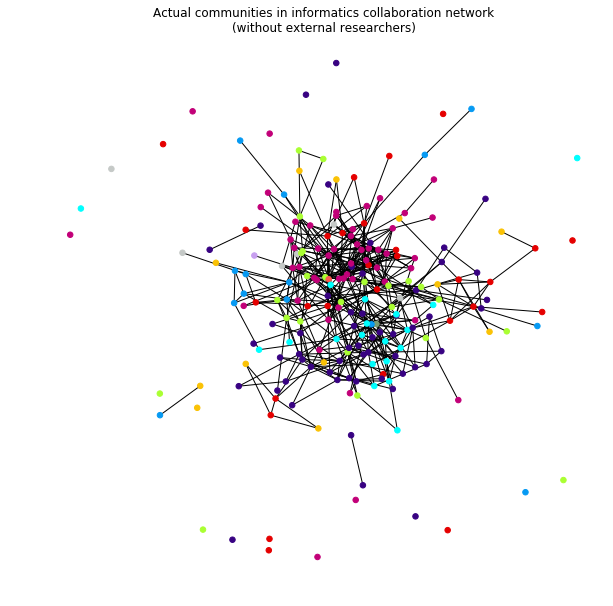

In [79]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.set_title(
    'Actual communities in informatics collaboration network\n(without external researchers)'
)
ax1.axis('off')
nx.draw_networkx(
    g_poinf_in_gcc,
    pos=pos_poinf,
    with_labels=False,
    ax=ax1,
    nodelist=poinf_in_gcc,
    edgelist=poinf_edge,
    node_size=30,
    node_color=color_by_inst(g_poinf_in_gcc))
# plt.savefig(
#     "full_graph-compareCommunities-big.pdf", format='pdf', bbox_inches="tight")

In [66]:
print(nx.info(g_poinf_in_gcc))

Name: Full collaboration Graph
Type: SubGraph
Number of nodes: 213
Number of edges: 474
Average degree:   4.4507


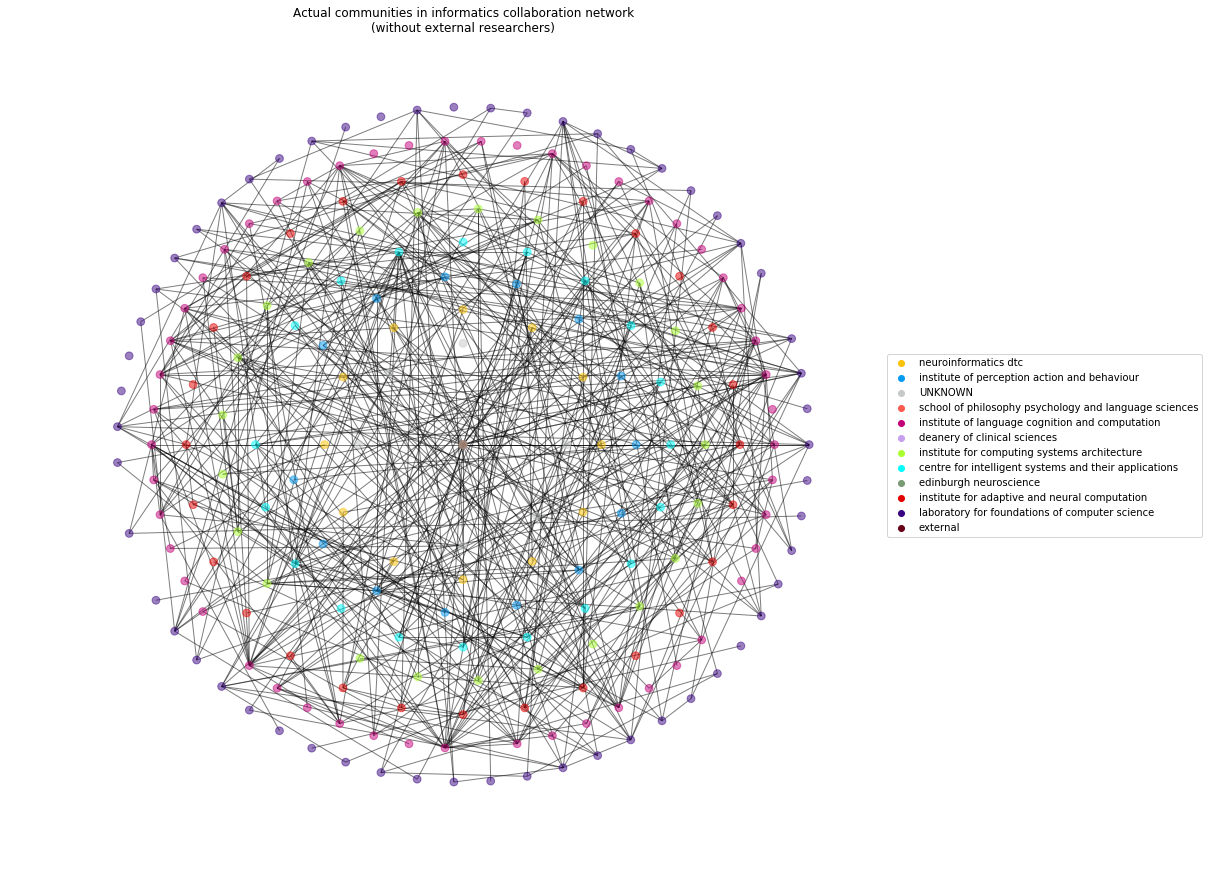

In [69]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111)
ax1.set_title('Actual communities in informatics collaboration network\n(without external researchers)')
ax1.axis('off')
ax1 = add_inst_labels(ax1)
nx.draw_networkx(
    g_poinf_in_gcc,
    pos=pos_poinf,
    with_labels=False,
    ax=ax1,
    node_size=60,
    alpha=.5,
    node_color=color_by_inst(g_poinf_in_gcc))
plt.show()

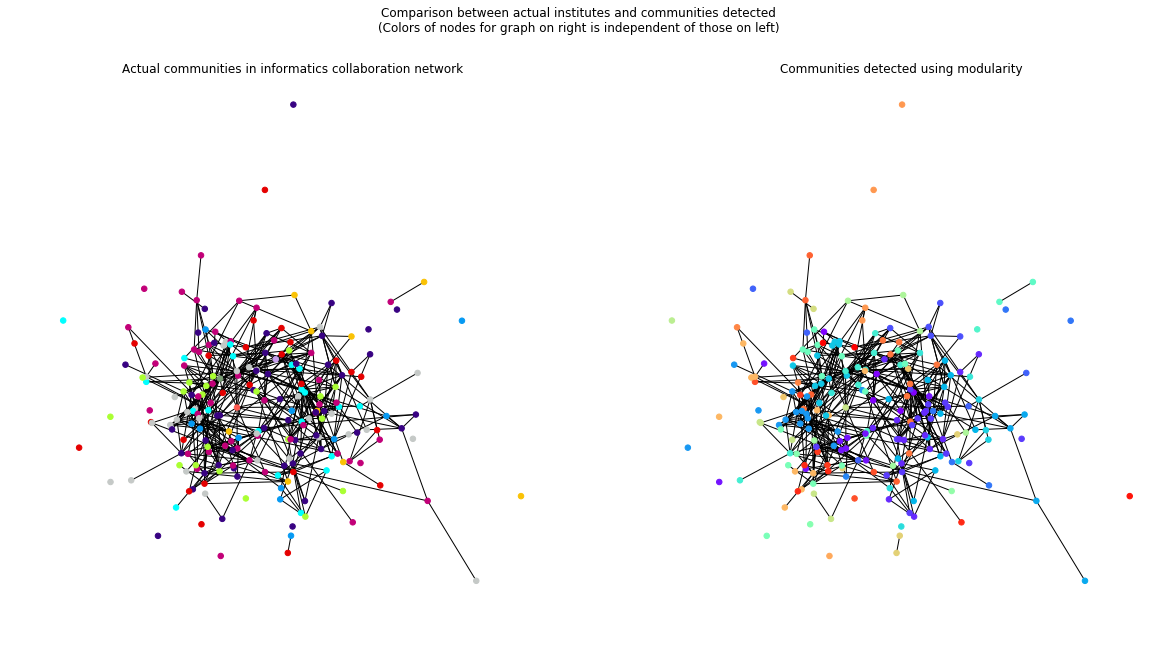

In [41]:
# Draw only nodes that are in informatics
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    nodelist=poinf_in_gcc,
    edgelist=poinf_edge,
    node_size=30,
    node_color=color_by_inst(nx.subgraph(main_gcc, poinf_in_gcc)))

ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    nodelist=poinf_in_gcc,
    edgelist=poinf_edge,
    node_size=30,
    node_color=[
        parts.get(node)
        for node in nx.subgraph(main_gcc, poinf_in_gcc).nodes()
    ],
    with_labels=False)

plt.savefig(
    "full_graph-compareCommunities-rmExt.pdf",
    format='pdf',
    bbox_inches="tight")

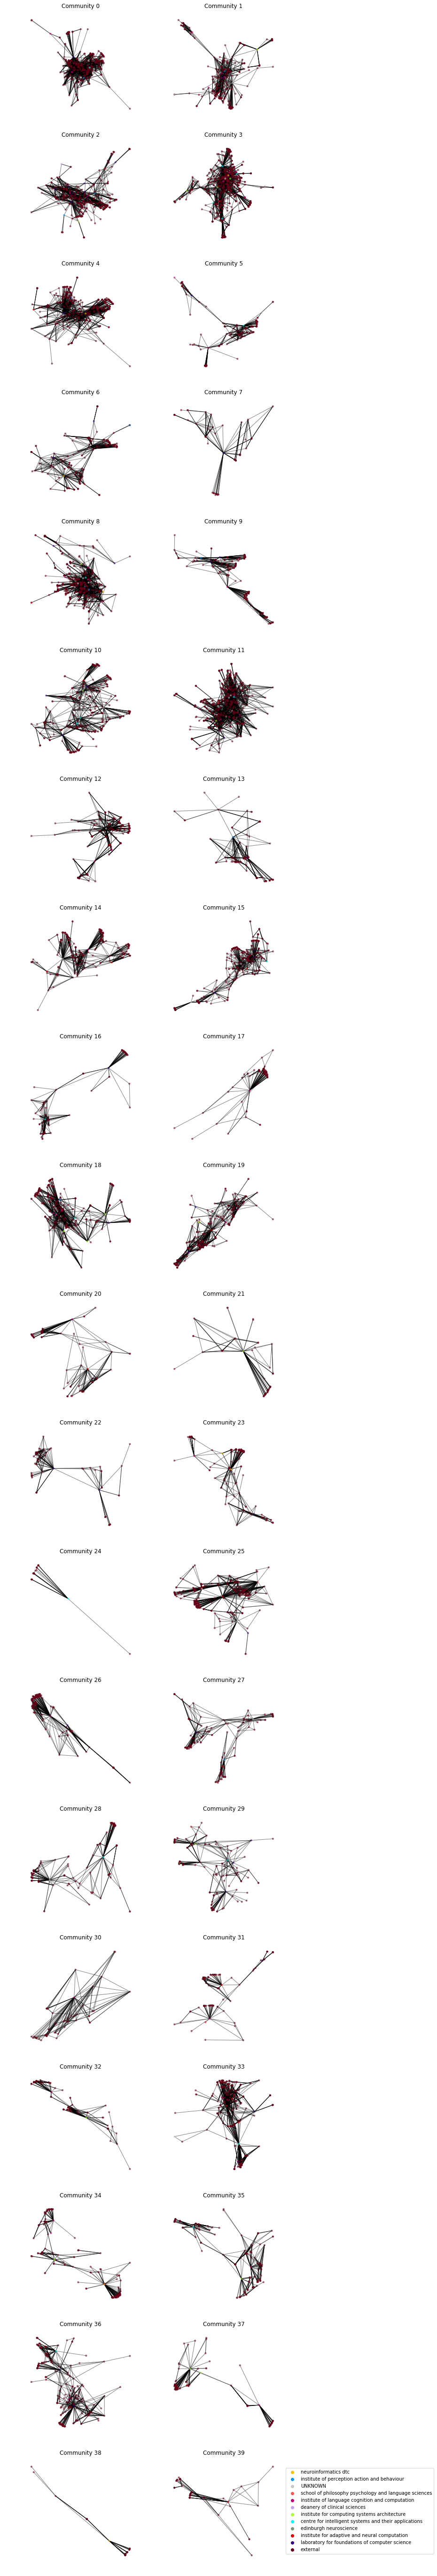

In [42]:
# plot each community:
fig = plt.figure(figsize=(10, 100))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(num_comm / 2, 2, i)
    # find those nodes belonging to this community:
    nodes_from_comm = [
        node_id for (node_id, c) in parts.items() if c == comm_id
    ]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(subG),
        node_size=10,
        alpha=.5,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig(
    "full_graph-compareSubCommunities.pdf", format='pdf', bbox_inches="tight")

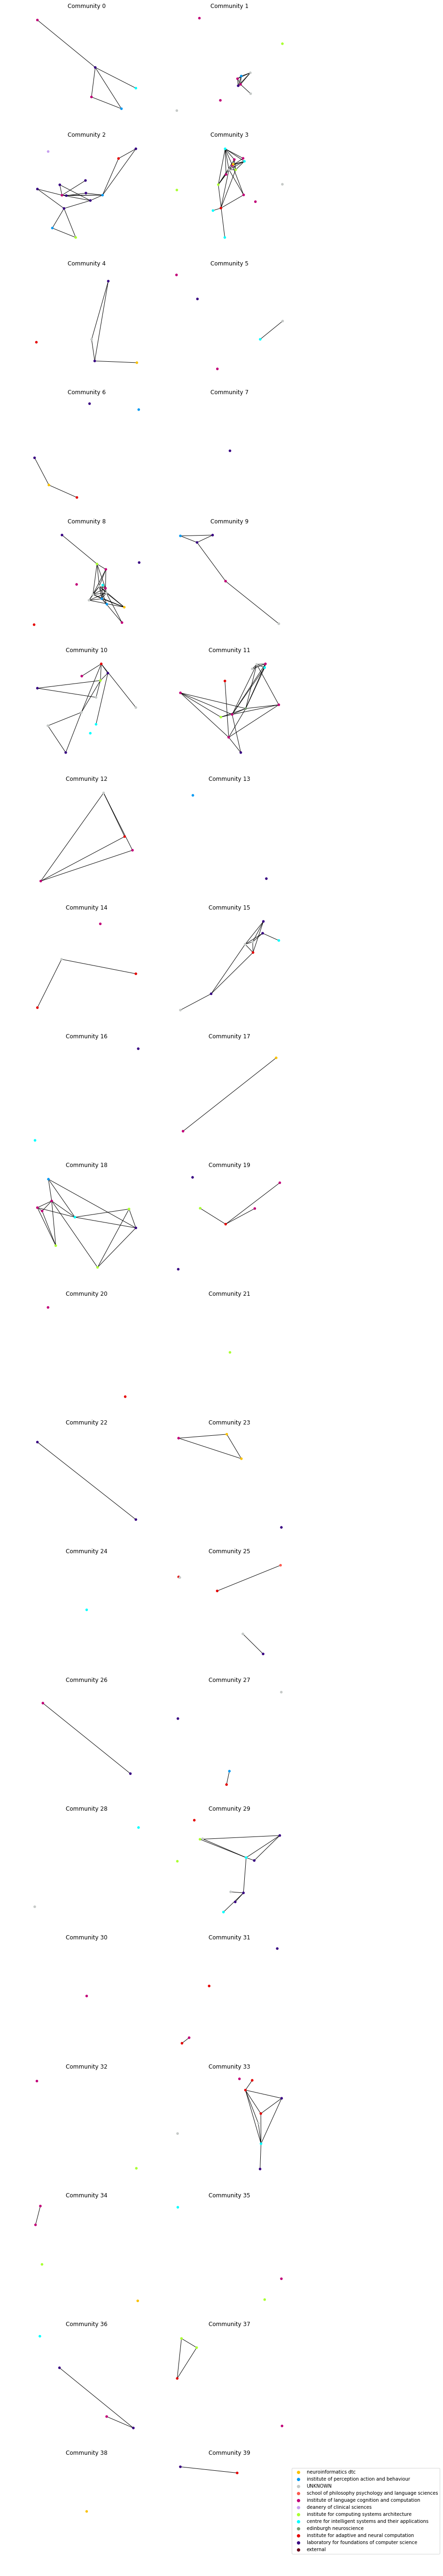

In [43]:
# plot each community:
fig = plt.figure(figsize=(10, 100))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(num_comm / 2, 2, i)
    # find those nodes belonging to this community:
    nodes_from_comm = [
        node_id for (node_id, c) in parts.items() if c == comm_id
    ]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    subsubG = nx.subgraph(subG, poinf_in_gcc)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    nx.draw_networkx(
        subsubG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(subsubG),
        node_size=20,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig(
    "full_graph-compareSubCommunities-rmExt.pdf",
    format='pdf',
    bbox_inches="tight")